In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate, ZGate
from PIL import Image as im
import requests
import base64
import matplotlib.pyplot as plt
import numpy as np
import io

from maze_oracle import MazeOracleGenerator

In [3]:
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    img = im.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
    plt.imshow(img)
    plt.axis('off') # allow to hide axis
    plt.savefig('image.png', dpi=1200)

In [12]:
def map_graph(edges, registry_size: int = 2, directed: bool = False):
    circ = QuantumCircuit((2 * registry_size) + 1, name='Graph Verify')
    def map_edge(from_node: int, to_node: int):
        target_qubit = (2 * registry_size)
        def add_x(number, start_qubit):
            exp = 1
            for qubit in range(start_qubit, start_qubit + registry_size):
                if not (number & exp):
                    circ.x(qubit)
                exp *= 2

        add_x(from_node, 0)
        add_x(to_node, registry_size)
        circ.append(XGate().control(registry_size * 2), list(range((2 * registry_size))) + [target_qubit])
        add_x(from_node, 0)
        add_x(to_node, registry_size)
    for e in edges:
        map_edge(e[0], e[1])
        circ.barrier()
        if not directed:
            map_edge(e[1], e[0])
            circ.barrier()
    return circ



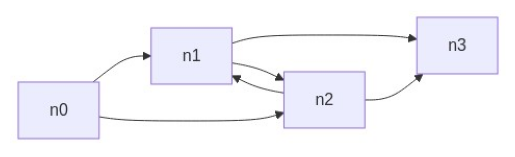

In [4]:
mm("""
flowchart LR;
   n0 --> n1 & n2
   n1 & n2 --> n3
   n1 --> n2
   n2 --> n1
""")

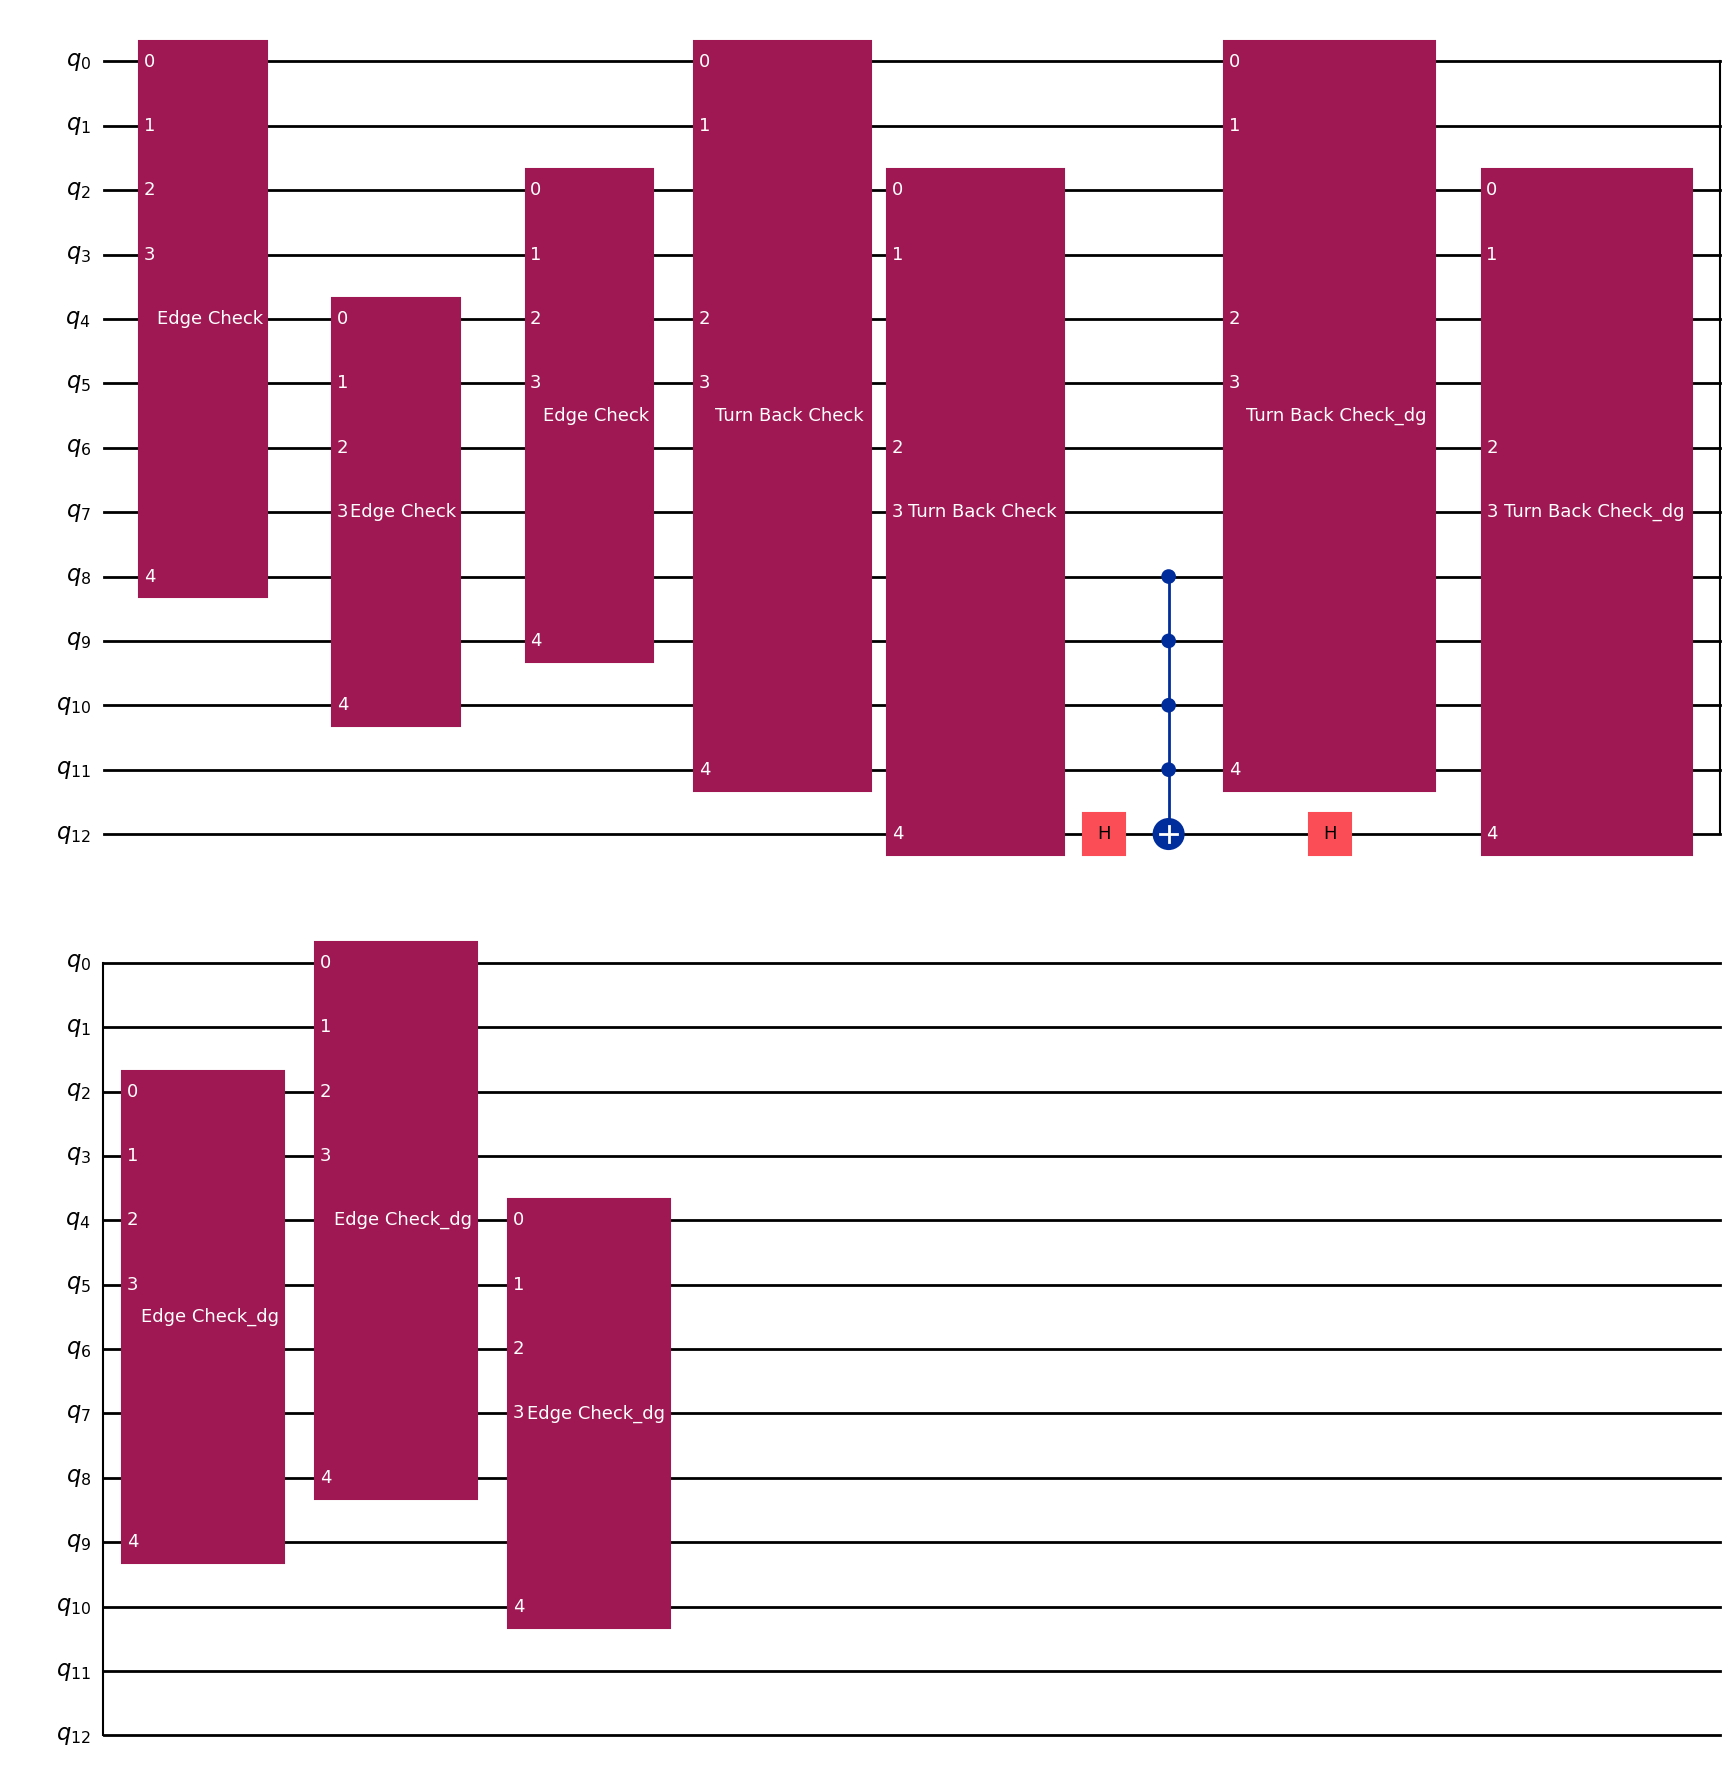

In [1]:
edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3)
]
from maze_oracle import MazeOracleGenerator
oracle = MazeOracleGenerator(4).add_edges(edges).set_first_node(0).set_last_node(3).generate()
oracle.decompose().draw('mpl')

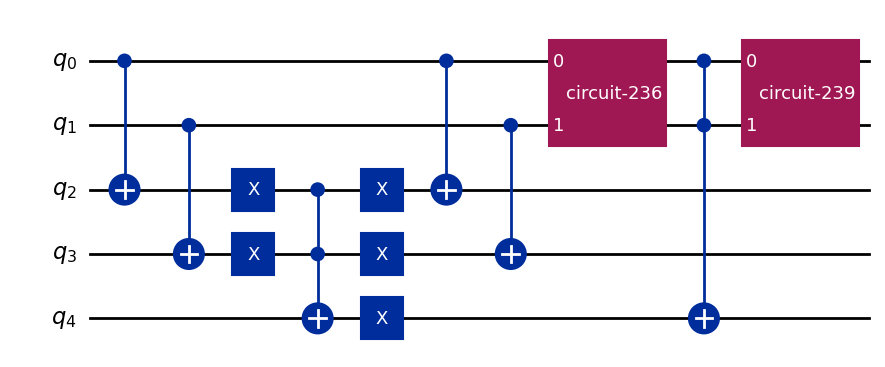

In [4]:
MazeOracleGenerator(4).add_edges(edges).set_first_node(0).set_last_node(3).generate_turn_back_check_circuit().draw('mpl')